In [11]:
import pickle
from script.util import LSTMModel, rmspe, maape
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from random import randint
import matplotlib.pyplot as plt
import networkx as nx
import epftoolbox 
from epftoolbox.evaluation import MASE


In [46]:
flow_file= "./data/PEMS04/pems04.npz"
csv_file = "./data/PEMS04/distance.csv"

data = np.load(flow_file)
df = pd.read_csv(csv_file)
TS = data['data']
flow = TS[:,:,0]

# flow dict 100 time series is the sensor number and the value the traffic flow times serie
flow_dict={k:flow[:,k] for k in range(307)}

# list of the first 10 connected sensor, each sensor traffic flow is contained in PeMS 
PeMS = pd.DataFrame(flow_dict)

# time serie of sensor k
#creation of the datetime index
start_date = "2018-01-01 00:00:00"
end_date = "2018-02-28 23:55:00"
interval = "5min"
index = pd.date_range(start=start_date, end=end_date, freq=interval)
PeMS = PeMS.set_index(index)

alpha = 0.2
for i in range(100):
    y = PeMS[PeMS.columns[i]]
    smoothed_values = [y[0]]
    for j in range(1, len(y)):
        smoothed_value = alpha * y[j] + (1 - alpha) * smoothed_values[-1]
        smoothed_values.append(smoothed_value)
    PeMS[PeMS.columns[i]] = smoothed_values

maximum = PeMS.max().max()


In [47]:
maximum

919.0

# Univarié Mean Flow

In [4]:
with open('./experiment/clusterS1.pkl', 'rb') as f:
    my_dict = pickle.load(f)

In [5]:
model = my_dict[0]['model']
test = my_dict[0]['test']

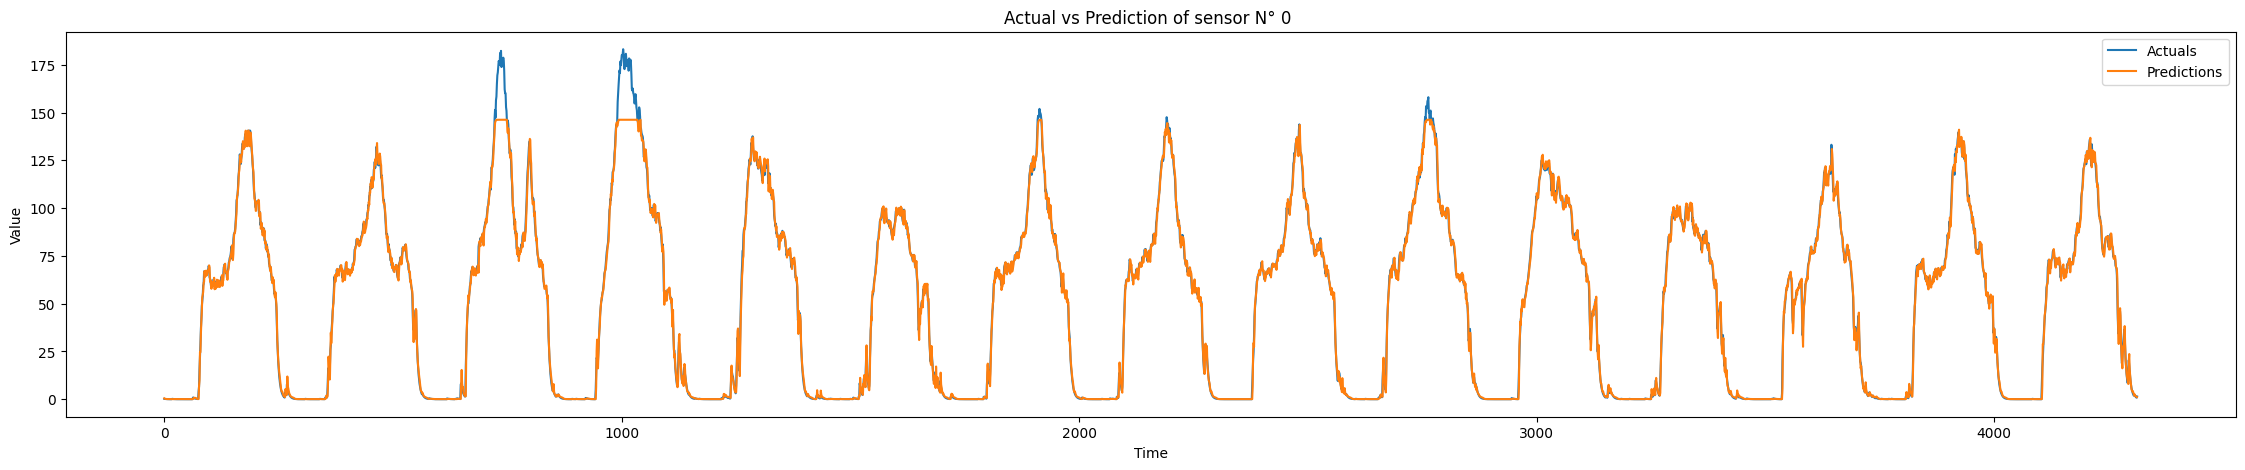

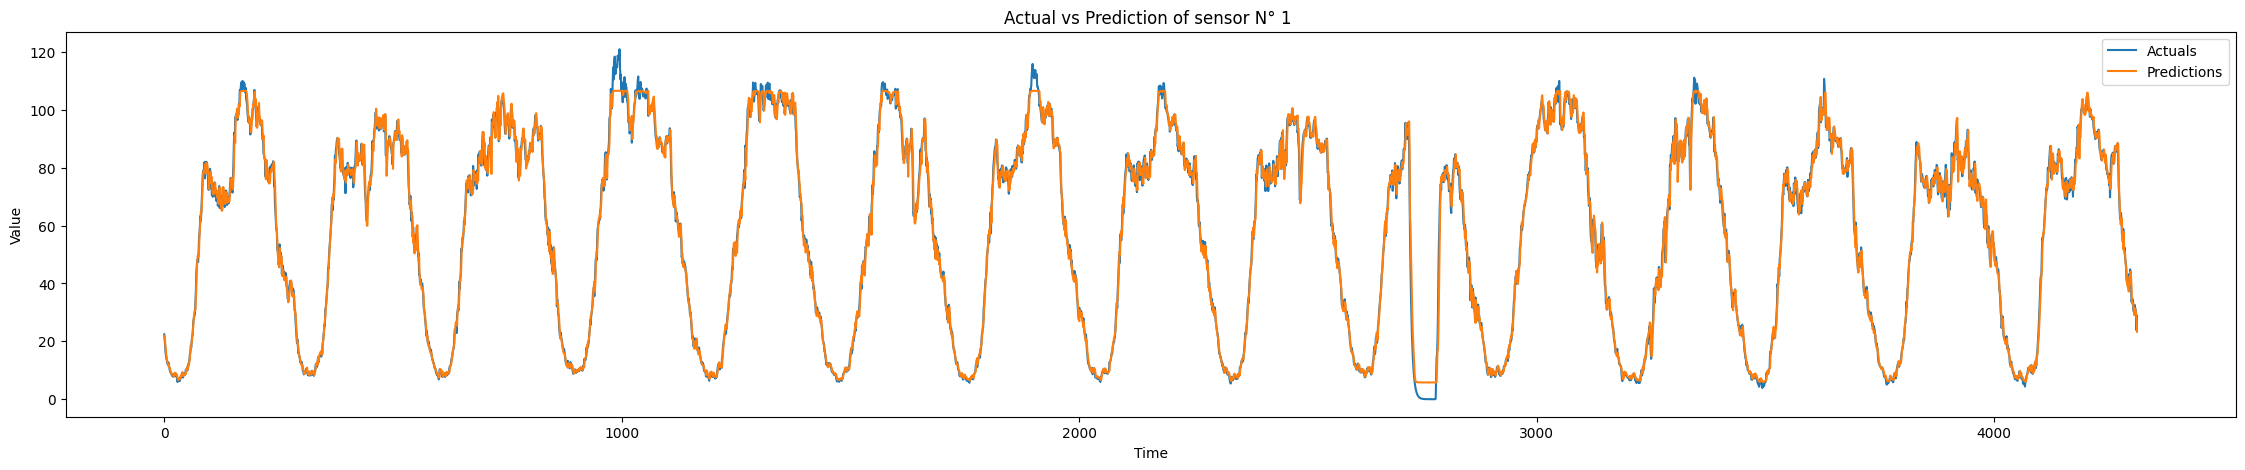

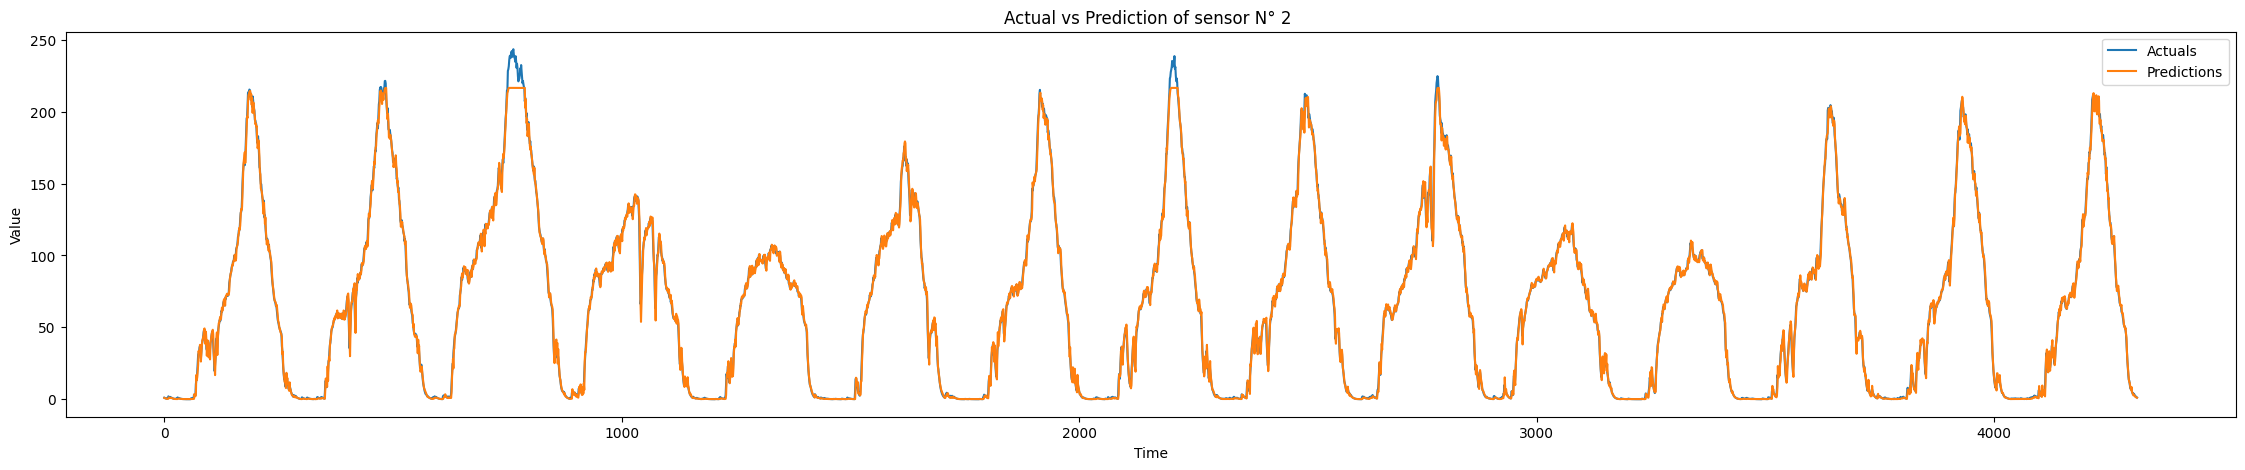

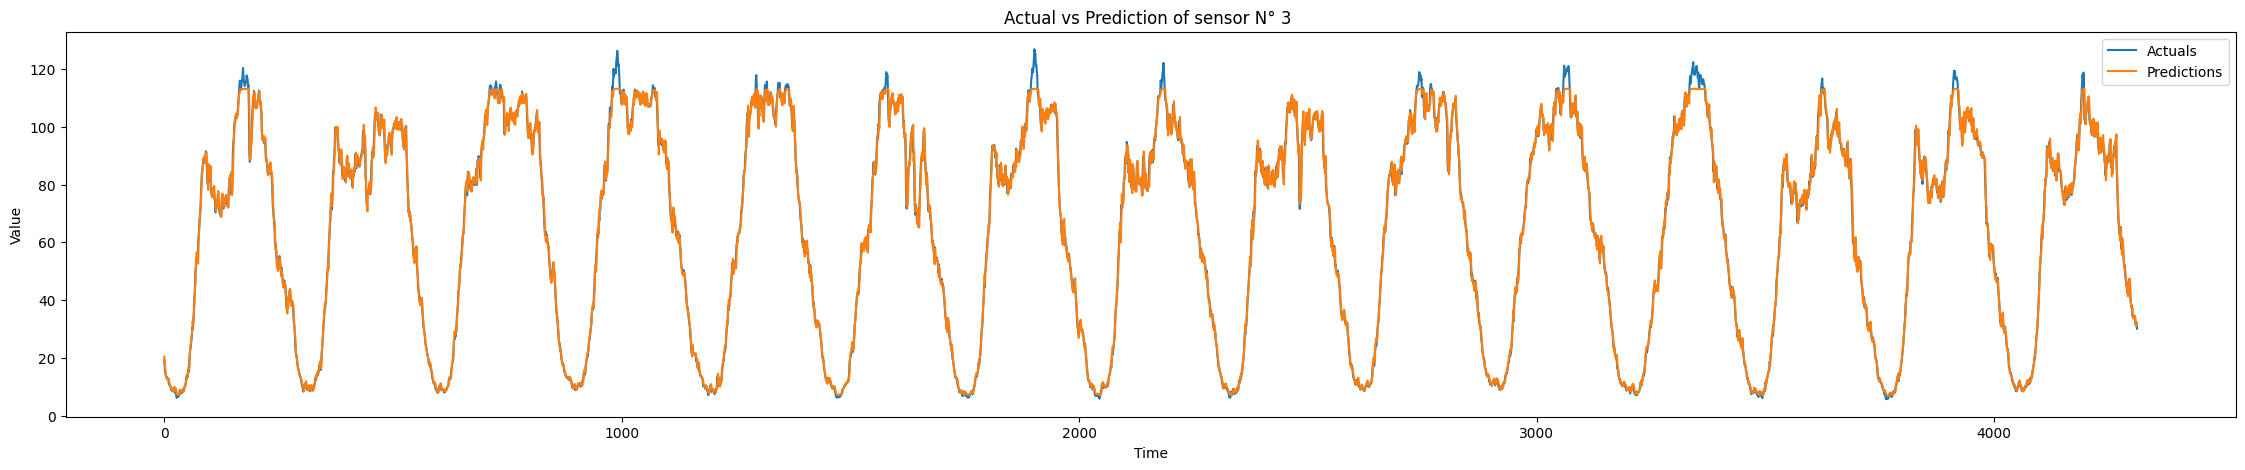

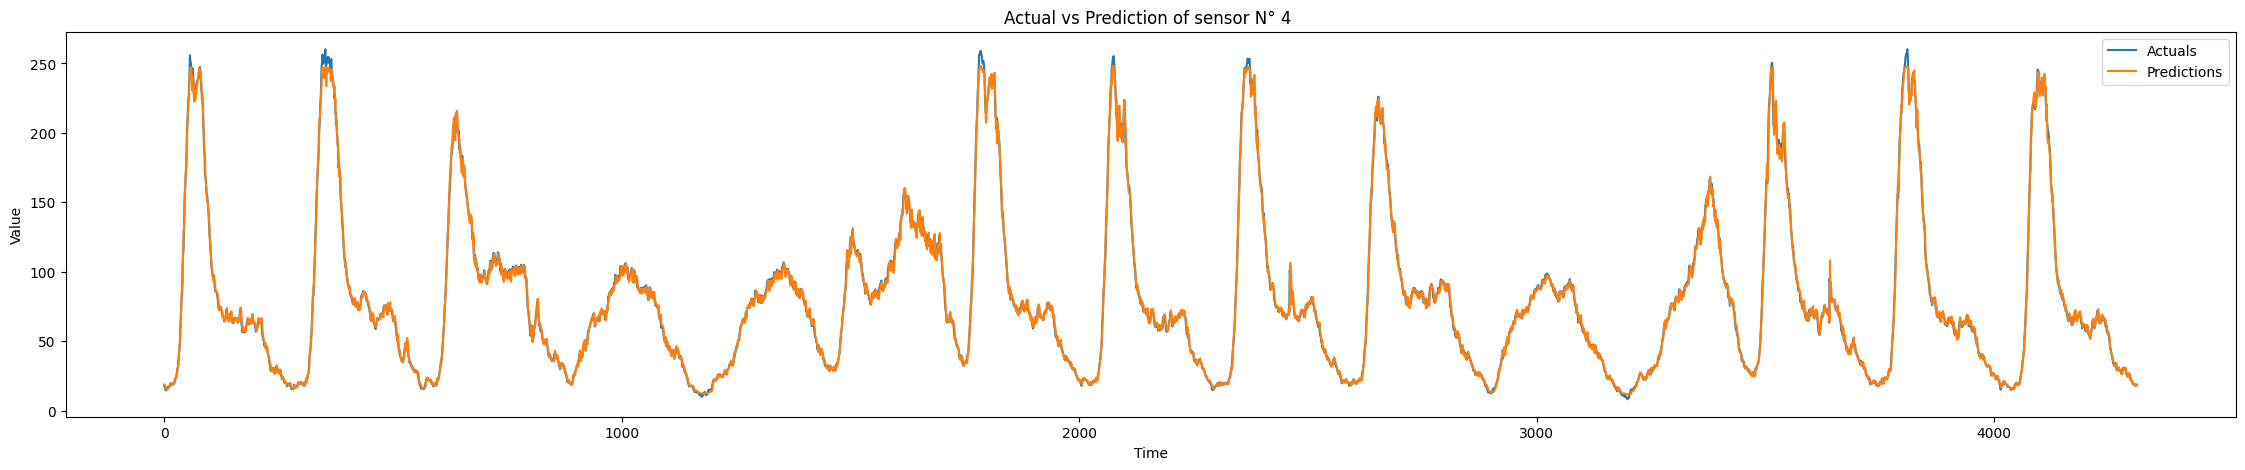

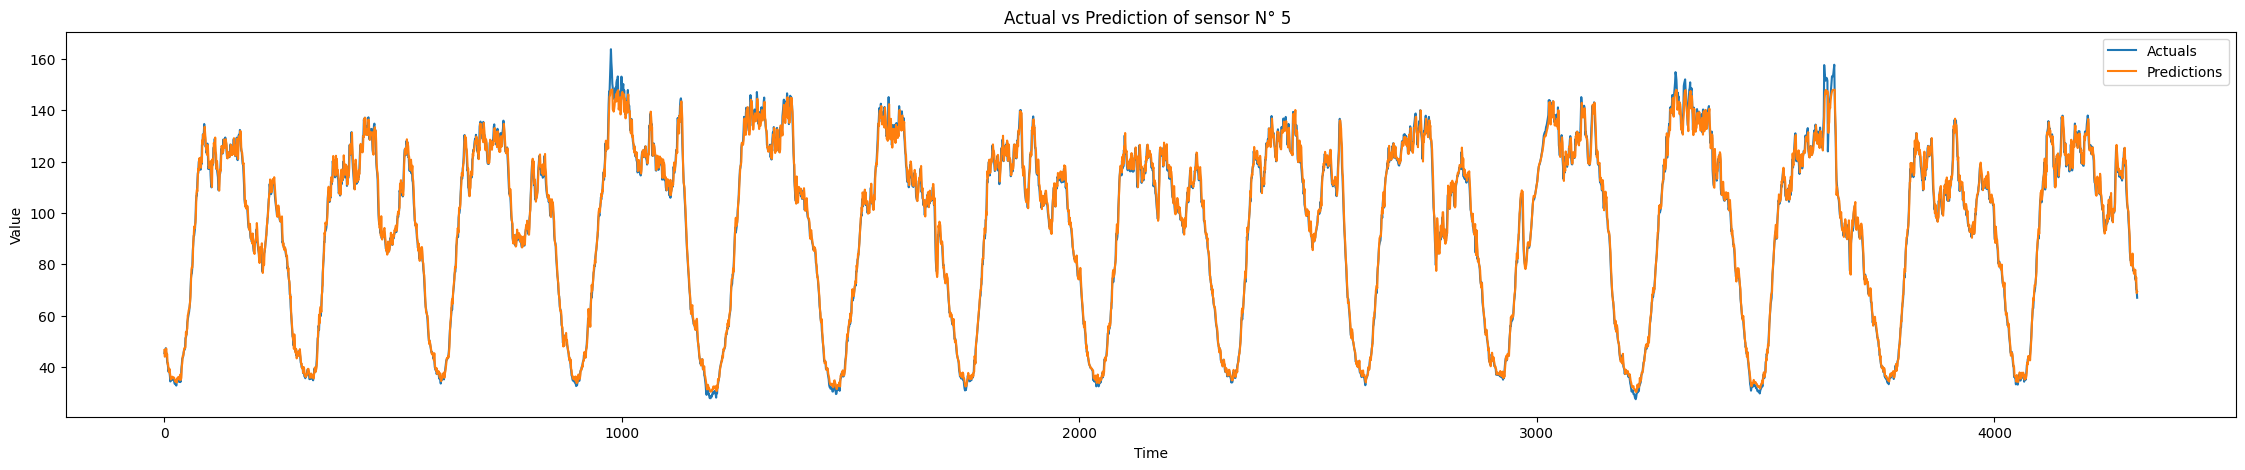

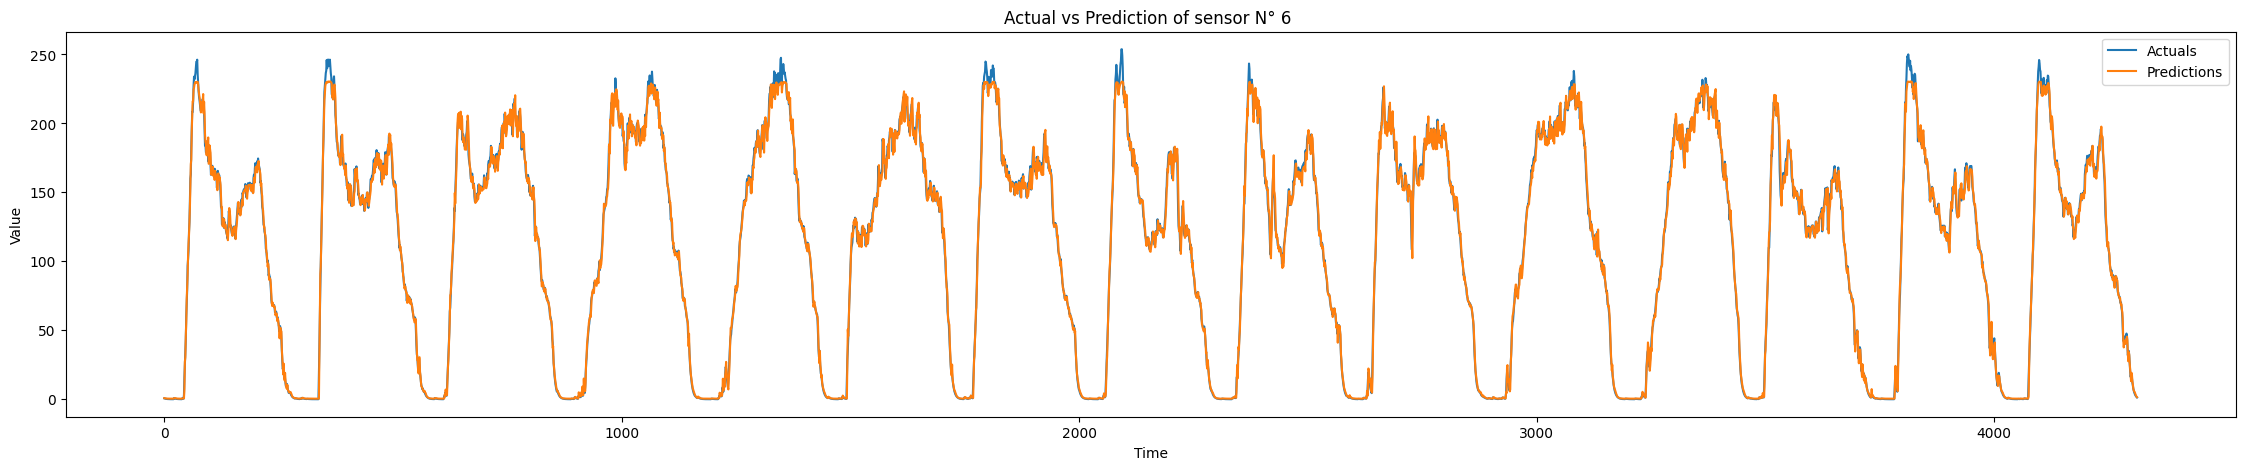

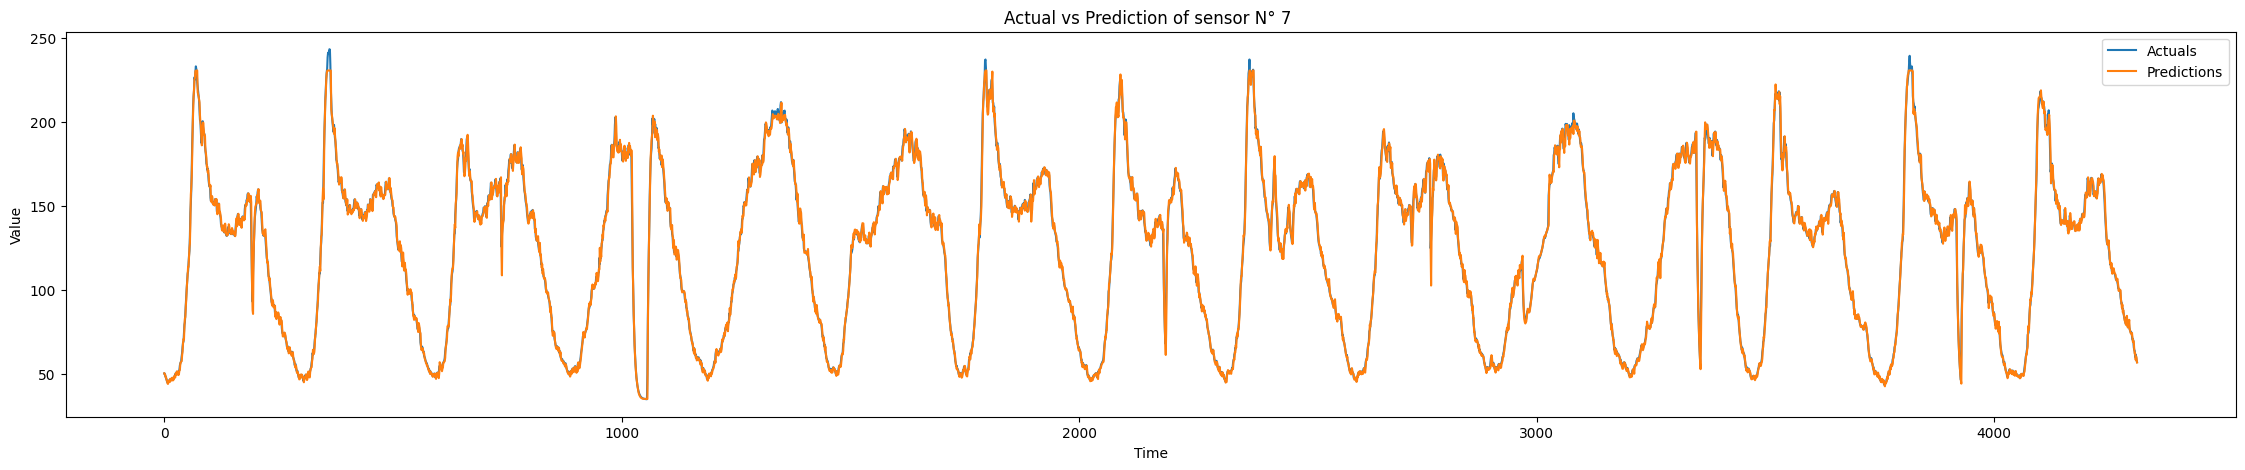

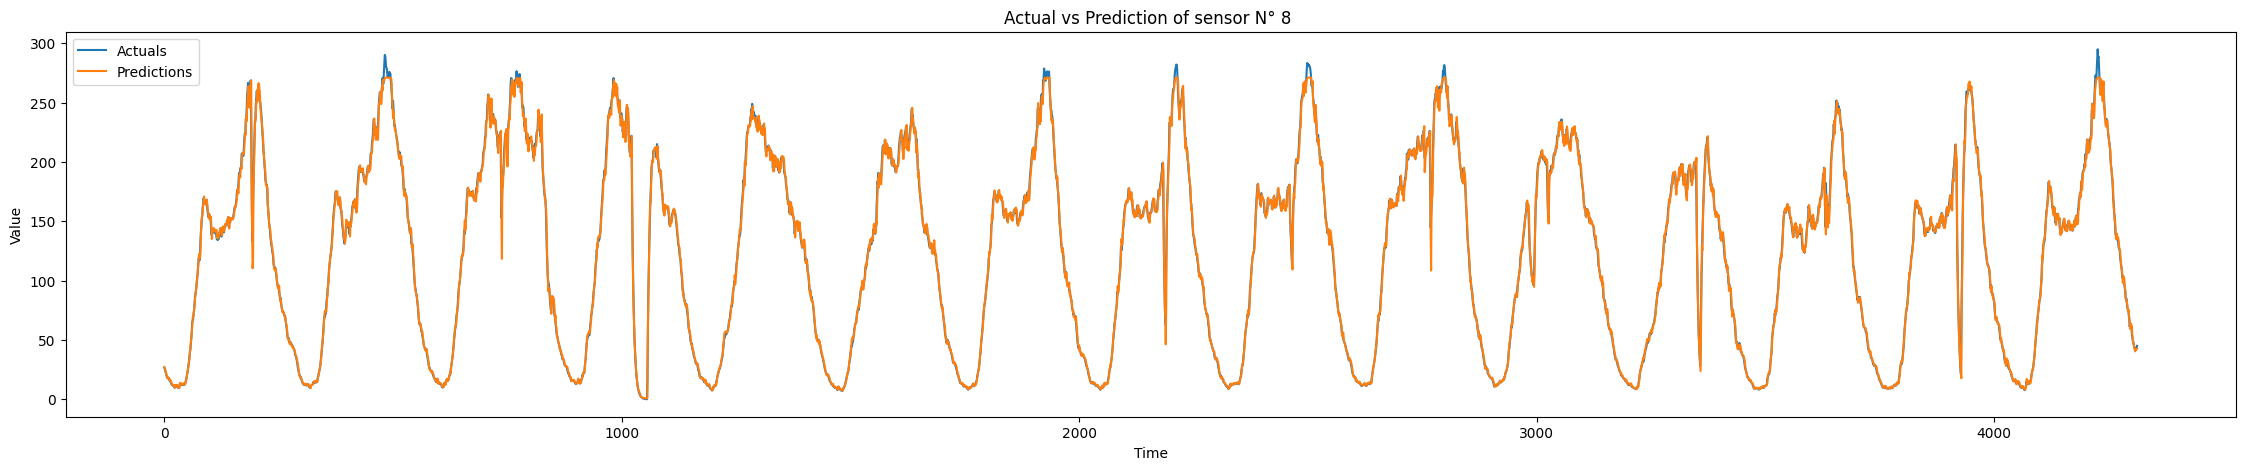

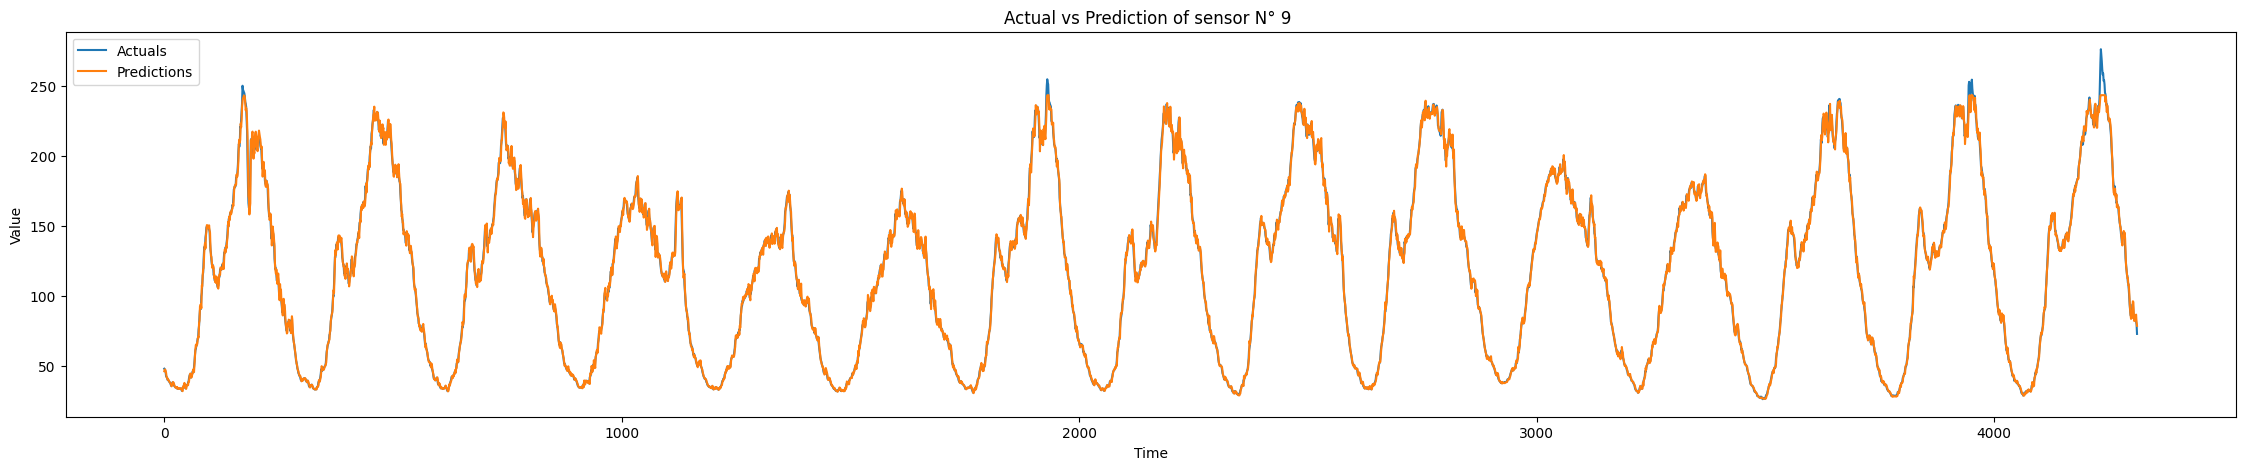

In [29]:
metric_dict={}
for j in range(60):
    metric_dict[j]={}
    model = my_dict[j]['model']
    test = my_dict[j]['test']
    criterion = torch.nn.MSELoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.double()
    model.to(device)
    model.eval()
    test_loader= test
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            x = torch.Tensor(inputs).unsqueeze(1).to(device)
            y = torch.Tensor(targets).unsqueeze(0).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    test_loss /= len(test_loader)
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    test_data = test
    window_size = 7
    EPSILON = 1e-10
   
    
    y_pred = predictions[:,0]
    y_true = actuals[:,0]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true,y_pred+EPSILON)
    maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100
    number_of_zero = len(y_true[y_true ==0])
    metric_dict[j]={"mae":mae,  "rmse":rmse,"maape":maape,"zero": y_true.min(),"mape":mape }

    if j<10 : 
       
        plt.figure(figsize=(28, 5))
        plt.title('Actual vs Prediction of sensor N° {} '.format(j))
        plt.plot(y_true, label='Actuals')
        plt.plot(y_pred, label='Predictions')
        # Add evaluation metrics to the plot
        #plt.annotate(f'RMSPE: {rmspe_val:.2f}', xy=(0.005, 0.55), xycoords='axes fraction')
        #plt.annotate(f'MAAPE: {maape:.2f}', xy=(0.005, 0.5), xycoords='axes fraction')
        # Set x and y labels
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        #print(f"RMSPE:{rmspe_val:.3f} % , MAAPE:{maape:.3f} %")
        plt.show()


In [30]:
metric_dict

{0: {'mae': 1.8946737341972928,
  'rmse': 3.994242728571824,
  'maape': 33.24636047177095,
  'zero': 8.101018005330377e-09,
  'mape': 8135.168475896193},
 1: {'mae': 2.065128914226275,
  'rmse': 2.899818557878012,
  'maape': 6.160164505655518,
  'zero': 0.00025957010140713896,
  'mape': 25.931472719076105},
 2: {'mae': 2.196021092676615,
  'rmse': 3.592793491935317,
  'maape': 14.600402460943073,
  'zero': 0.0006476836548449017,
  'mape': 0.4235962417946523},
 3: {'mae': 1.7249099752889296,
  'rmse': 2.396972973349078,
  'maape': 3.510605249299898,
  'zero': 5.6864864236024335,
  'mape': 0.03519376369903078},
 4: {'mae': 2.2509682998033673,
  'rmse': 3.2758335784042485,
  'maape': 3.301488416069313,
  'zero': 8.263913565192803,
  'mape': 0.033089038788871504},
 5: {'mae': 2.1508056572233603,
  'rmse': 2.8583096701988326,
  'maape': 2.3765936077221834,
  'zero': 27.439717512040993,
  'mape': 0.023782840332209527},
 6: {'mae': 3.4200102929061766,
  'rmse': 4.938368060369169,
  'maape': 1

# Multivarié Mean Flow

In [ ]:
with open('./experiment/clusterS5.pkl', 'rb') as f:
    dict5 = pickle.load(f)
with open('./experiment/clusterS10.pkl', 'rb') as f:
    dict10 = pickle.load(f)
with open('./experiment/clusterS15.pkl', 'rb') as f:
    dict15 = pickle.load(f)

In [63]:
dict.keys()

dict_keys(['size', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [71]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from random import randint
def my_metrics_dict(dict):
    #Load the best model and evaluate on the test set
    size = dict["size"]
    for s in range(60):
        best_model = dict[s]["model"]
        best_model.double()
        best_model.to(device)
        test_loader = dict[s]["test"]
        best_model.eval()

        # Evaluate the model on the test set
        test_loss = 0.0
        predictions = []
        actuals = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(test_loader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                x = torch.Tensor(inputs).unsqueeze(1).to(device)
                y = torch.Tensor(targets).unsqueeze(0).to(device)
                outputs = best_model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                # Save the predictions and actual values for plotting later
                predictions.append(outputs.cpu().numpy())
                actuals.append(targets.cpu().numpy())
                
        test_loss /= len(test_loader)
        # Concatenate the predictions and actuals
        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)
        EPSILON = 1e-10
        metric_dict_multi = {}
        for j in range(60): 
            metric_dict_multi[j] = {}
            for k in range(size): 
                y_pred = predictions[:,k]*maximum
                y_true = actuals[:,k]*maximum
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae = mean_absolute_error(y_true, y_pred)
                mape = mean_absolute_percentage_error(y_true,y_pred+EPSILON)
                maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100
                number_of_zero = len(y_true[y_true ==0])
                metric_dict_multi[j][j+k]={"mae":mae,  "rmse":rmse,"maape":maape,"zero": y_true.min(),"mape":mape }
    return metric_dict_multi

In [ ]:
with open('./experiment/clusterS5.pkl', 'rb') as f:
    dict5 = pickle.load(f)
metric5 = my_metrics_dict(dict5)

In [73]:
del dict5
with open('./experiment/clusterS10.pkl', 'rb') as f:
    dict5 = pickle.load(f)
metric10 = my_metrics_dict(dict5)

In [76]:
del dict5
with open('./experiment/clusterS15.pkl', 'rb') as f:
    dict5 = pickle.load(f)
metric15 = my_metrics_dict(dict5)

In [78]:
with open('./experiment/metric.pkl', 'wb') as f:
    pickle.dump({1:metric_dict,5:metric5,10:metric10, 15:metric15 },f)
    

# Test